### This code will merge patches with the central_tendency method and upscale with bicubic interpolation

In [1]:
import os
import glob

import skimage
import numpy as np
import random

import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

from shutil import copyfile

from shutil import copytree
from shutil import rmtree

from supreshelper import *

In [2]:
data_path = "Data/"
data_generated = "DataGenerated"

train = glob(data_path +  "train/*/*") 
test = glob(data_path + "test/*/*") 

In [3]:
def mergeAndUpscale(scene_path):
    merged = central_tendency(scene_path, agg_with='median', only_clear=False)
    return bicubic_upscaling(merged)

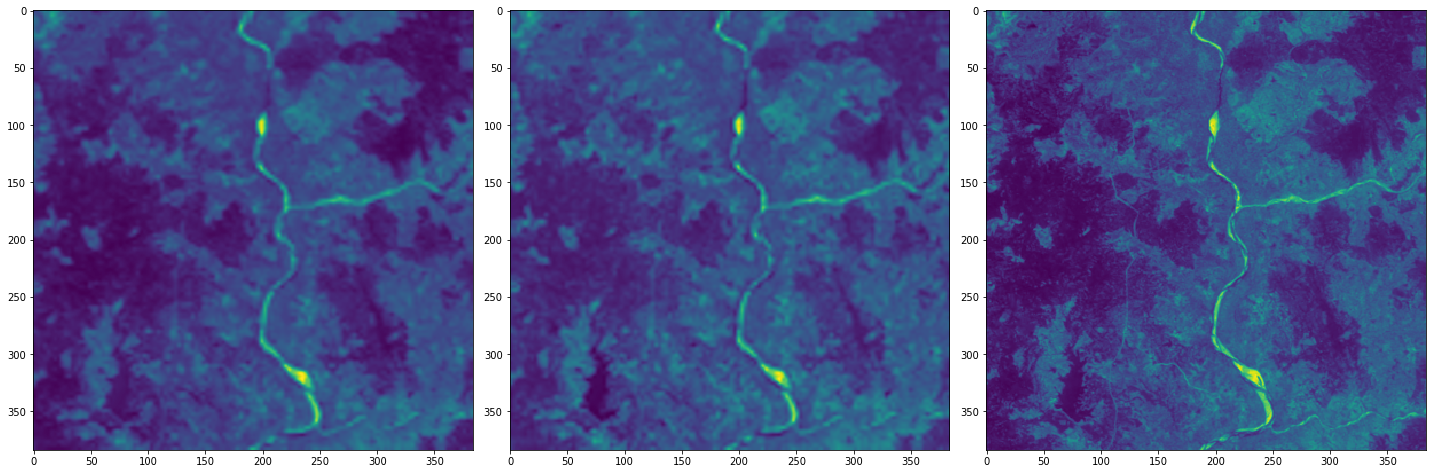

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,3,1)
plt.imshow(mergeAndUpscale(train[1]))

ax = fig.add_subplot(1,3,2)
plt.imshow(baseline_upscale(train[1]))
 
ax = fig.add_subplot(1,3,3)
plt.imshow(highres_image(train[1])[0])

plt.tight_layout()

In [5]:
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value.flatten()]))

In [6]:
def array_to_tfrecords(all_, output_file):
    feature ={ "all": tf.train.Feature(float_list=tf.train.FloatList(value=all_.flatten()))}
    
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    serialized = example.SerializeToString()

    writer = tf.io.TFRecordWriter(output_file)
    writer.write(serialized)
    writer.close()

In [7]:
def saveScene(scene_path):
    new_path = data_generated + "/" + "/".join(scene_path.split("/")[1:])
    os.makedirs(new_path, exist_ok=True)
    
    LR_up = mergeAndUpscale(scene_path)
    
    if scene_path.split("/")[1] == "train":
        HR = skimage.img_as_float64(skimage.io.imread(scene_path + "/" + 'HR.png'))
        SM = skimage.img_as_float64(skimage.io.imread(scene_path + "/" + 'SM.png'))
        #skimage.io.imsave(new_path + "/" + "all.png", skimage.img_as_uint(np.concatenate([LR_up, HR, SM], axis=1)))
        #np.save(new_path + "/" + "all.npy", np.concatenate([LR_up, HR, SM], axis=1))
        array_to_tfrecords(np.concatenate([LR_up, HR, SM], axis=1), new_path + "/" + "all.tfrecords")
        
    else:
        #skimage.io.imsave(new_path + "/" + "up_LR.png", skimage.img_as_uint(LR_up))
        #np.save(new_path + "/" + "up_LR.npy", LR_up)
        array_to_tfrecords(LR_up, new_path + "/" + "up_LR.tfrecords")
    
    for f in glob(scene_path+ "/*"):
        copyfile(f,  data_generated + "/" + "/".join(f.split("/")[1:]))

In [8]:
for scene in train + test:
    saveScene(scene);

### Move 30 random scenes to the dev directory for validation

In [9]:
for scene in random.sample(glob(data_generated +  "/train/*/*"), 30):
    
    scene_elem = scene.split("/")
    dst = data_generated + "/dev/" + "/".join(scene_elem[2:])
    copytree(scene, dst)
    rmtree(scene)